In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib



In [3]:
df = pd.read_csv("irrigation_machine.csv")


In [4]:
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])


In [5]:
X = df.loc[:, df.columns.str.startswith('sensor')]  # Sensor feature columns
y = df.loc[:, df.columns.str.startswith('parcel')]  # Parcel target columns


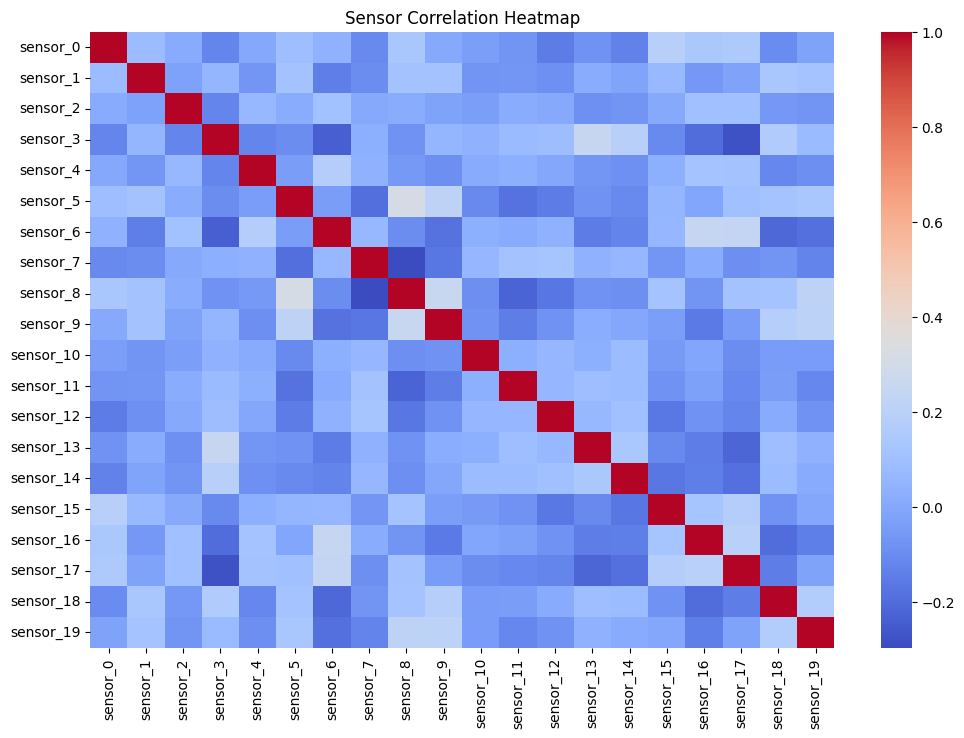

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), cmap="coolwarm", annot=False)
plt.title("Sensor Correlation Heatmap")
plt.show()


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
param_grid = {
    "estimator__n_estimators": [100, 200],
    "estimator__max_depth": [8, 12],
    "estimator__min_samples_split": [2, 4],
}

rf = RandomForestClassifier(random_state=42)
multi_rf = MultiOutputClassifier(rf)

grid_search = GridSearchCV(
    multi_rf, param_grid, cv=3, n_jobs=-1, verbose=1, scoring="accuracy"
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Best hyperparameters found:", grid_search.best_params_)



Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best hyperparameters found: {'estimator__max_depth': 12, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 200}


In [10]:
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       254
           1       0.87      0.95      0.91       292
           2       0.87      0.48      0.62        85

   micro avg       0.87      0.90      0.88       631
   macro avg       0.87      0.80      0.81       631
weighted avg       0.87      0.90      0.87       631
 samples avg       0.80      0.78      0.78       631



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


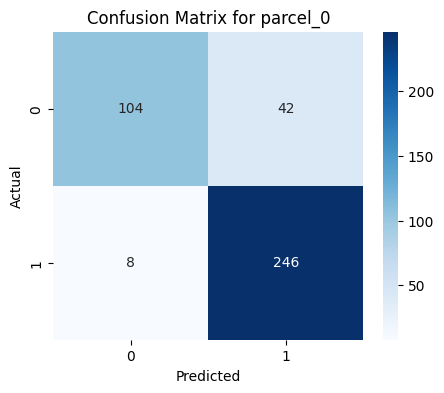

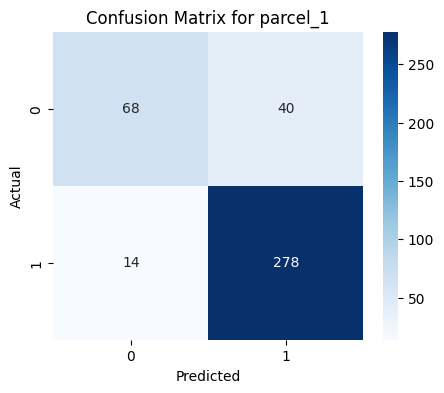

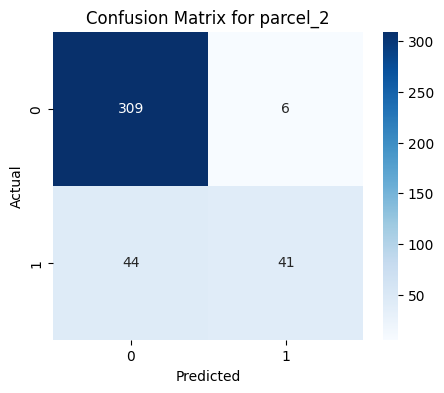

In [11]:
for idx, col in enumerate(y.columns):
    cm = confusion_matrix(y_test.iloc[:, idx], y_pred[:, idx])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {col}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()



In [12]:

try:
    roc_auc = roc_auc_score(y_test, y_pred, average="macro")
    print(f"Macro ROC-AUC Score: {roc_auc:.3f}")
except Exception:
    print("ROC-AUC score could not be calculated (check target format).")


Macro ROC-AUC Score: 0.788


In [13]:
importances = np.mean(
    [est.feature_importances_ for est in best_model.estimators_], axis=0
)
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print("\nTop 10 Most Important Sensors:\n")
print(feature_importance.head(10))



Top 10 Most Important Sensors:

sensor_6     0.081164
sensor_0     0.073423
sensor_15    0.071601
sensor_17    0.069198
sensor_8     0.063638
sensor_12    0.063552
sensor_3     0.059384
sensor_5     0.052944
sensor_16    0.049308
sensor_9     0.046543
dtype: float64


/tmp/ipython-input-3210971221.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


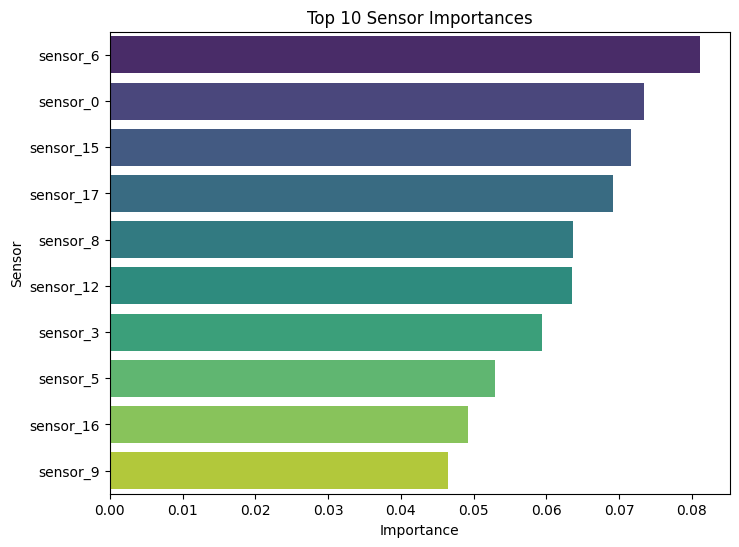

In [14]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x=feature_importance.head(10),
    y=feature_importance.head(10).index,
    palette="viridis",
)
plt.title("Top 10 Sensor Importances")
plt.xlabel("Importance")
plt.ylabel("Sensor")
plt.show()


In [15]:

joblib.dump(best_model, "Farm_Irrigation_System.pkl")
joblib.dump(scaler, "sensor_standard_scaler.pkl")

print("\nModel and scaler saved as 'Farm_Irrigation_System.pkl' and 'sensor_standard_scaler.pkl'.")



Model and scaler saved as 'Farm_Irrigation_System.pkl' and 'sensor_standard_scaler.pkl'.
